# Non-negative matrix factorization (NMF), singular value decomposition (SVD), TF-IDF and co-occurrence matrices
In this notebook I'm showing how to analyse labels of a multi-label image dataset (crawled from unsplash.com) by using SVD, NMF, TF-IDF and co-occurrence matrices.

In [1]:
import collections
import numpy as np
import scipy.sparse
import scipy.linalg
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import pickle
import imageio
import sklearn.decomposition

In [2]:
with open('./metadata.pickle', 'rb') as f:
    metadata = pickle.load(f)

The dataset contains about 75,000 images, each with multiple associated labels.

In [3]:
print(len(metadata.keys()))
metadata['QSzdNJvF-Ak'] # the keys are image ids

75559


{'high_conf_tags': {'electric',
  'guitar',
  'guitarist',
  'male',
  'man',
  'music',
  'musician',
  'performance',
  'performer',
  'person'},
 'low_conf_tags': {'instrument', 'jazz', 'west-jakarta%2C-indonesia'},
 'featured_in_collections': {'1301616', '1458283', '2457190'},
 'available_variants': ['', '_LL', '_RR', '_L', '_R']}

In [4]:
# clean up metadata and merge high and low confidence tags
images = list(metadata.keys())
tags = [metadata[i]['high_conf_tags'] | metadata[i]['low_conf_tags'] for i in images]
all_tags = [item for sublist in tags for item in sublist]
unique_tags = set(all_tags)

len(all_tags), len(unique_tags)

(1324616, 73890)

only use tags with more that 20 occurrences:

In [5]:
counter = collections.Counter(all_tags)
selected_tags = list(map(lambda x: x[0], filter(lambda x: x[1]>20, counter.most_common())))
print(len(selected_tags), selected_tags[:10])

4204 ['woman', 'cloud', 'light', 'building', 'forest', 'blue', 'wallpaper', 'man', 'nature', 'girl']


## Creating an occurrence matrix

The occurrence matrix is a sparse binary matrix of dimensions (number of unique tags)x(number of images) and associates each image with its tags. 'lil_matrix' is the most efficient matrix type for iteratively creating a sparse matrix.

In [6]:
num_of_images = 10000

In [7]:
occurrence_matrix = scipy.sparse.lil_matrix((len(selected_tags), len(tags[:num_of_images])))

Enter all occurrences into the occurrence matrix

In [8]:
%%time

def get_indices(t):
    return np.array([selected_tags.index(v) for v in t if v in selected_tags], dtype=np.int)

for i, image_tags in enumerate(tqdm(tags[:num_of_images])):
    occurrence_matrix[get_indices(image_tags), i] = True

/home/dominik/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/dominik/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/dominik/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:



CPU times: user 6.37 s, sys: 72 ms, total: 6.44 s
Wall time: 6.37 s


In [9]:
# convert the lil_matrix to a csr_matrix since they are more efficient for arithmetic ops
occurrence_matrix = scipy.sparse.csr_matrix(occurrence_matrix)

### Use TF-IDF to normalize tag occurrence frequencies.  
This assigns a higher significance to rare tags.  
`IDF = log(# of images / # images with tag t)`

In [10]:
idf = np.log(occurrence_matrix.shape[1]/(np.sum(occurrence_matrix, axis=1).squeeze()+0.1))
occurrence_matrix = occurrence_matrix.multiply(idf.T)
occurrence_matrix = occurrence_matrix.tocsr()

Show the occurrences of the 2000 most common tags for a random selection of 100 images.
Images are on the x-axis, tags are on the y-axis where more common tags are at the top.  
The color gradient is due to the TF-IDF normalization.

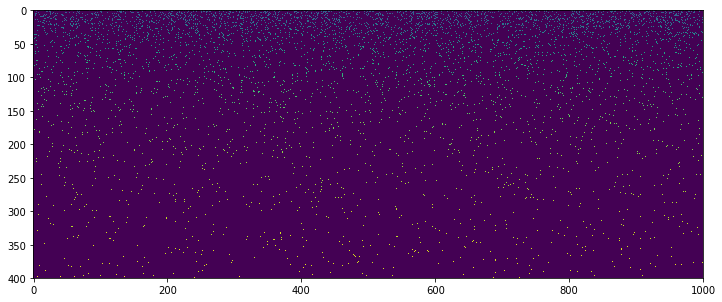

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(occurrence_matrix[:400, :1000].toarray())
plt.show()

## Creating the co-occurrence matrix

In [12]:
co_occurrence_matrix = occurrence_matrix * occurrence_matrix.T
co_occurrence_matrix.shape

(4204, 4204)

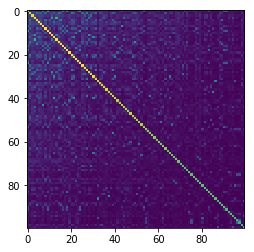

In [13]:
plt.imshow(co_occurrence_matrix[:100, :100].toarray())

## Clustering related tags using the co-occurrence matrix

In [14]:
print('*Related tags*\n')
for k in range(0, 2000, 130):
    m = np.array(selected_tags)[np.argsort(co_occurrence_matrix[k].toarray()[0])[::-1][:5]]
    print("{:<19}{:<3}{}".format(selected_tags[k], '→', str(m)))

*Related tags*

woman              →  ['woman' 'girl' 'female' 'portrait' 'person']
boat               →  ['boat' 'water' 'sea' 'lake' 'ocean']
brunette           →  ['brunette' 'female' 'girl' 'portrait' 'lady']
flat-lay           →  ['flat-lay' 'flatlay' 'food' 'cup' 'coffee']
black-background   →  ['black-background' 'black' 'black-wallpapers' 'dark' 'moon']
halloween          →  ['halloween' 'pumpkin' 'autumn' 'fall' 'scary']
beer               →  ['beer' 'alcohol' 'drink' 'bar' 'food']
lightbulb          →  ['lightbulb' 'bulb' 'filament' 'light' 'light-bulb']
reptile            →  ['reptile' 'lizard' 'snake' 'animal' 'wildlife']
parked             →  ['parked' 'car' 'road' 'street' 'vehicle']
one                →  ['one' 'single' 'little' 'boy' 'flower']
spice              →  ['spice' 'herb' 'food' 'healthy' 'spoon']
caffeine           →  ['caffeine' 'coffee' 'cup' 'cafe' 'beverage']
netherlands        →  ['netherlands' 'amsterdam' 'amsterdam%2C-netherlands' 'christma' 'dark']
toa

## Non-negative matrix factorization (NMF)

NMF factors a non-negative matrix into two non-negative matrices, W and H.  
If the input matrix has shape `(u, v)` then `W.shape = (u, d)` and `H.shape = (d, v)` where d is the number of components.

In [15]:
d = 20 # number of "clusters" (columns in the first result matrix)

In [16]:
clf = sklearn.decomposition.NMF(n_components=d, random_state=1)

W = clf.fit_transform(occurrence_matrix)
H = clf.components_

W.shape, H.shape

((4204, 20), (20, 10000))

### Show related tags

In [17]:
for k in range(d):
    print(np.array(selected_tags)[np.argsort(W[:, k])[::-1]][:6])

['mountain' 'landscape' 'forest' 'cloud' 'rock' 'tree']
['female' 'girl' 'portrait' 'woman' 'fashion' 'model']
['city' 'building' 'architecture' 'urban' 'street' 'cityscape']
['flower' 'plant' 'petal' 'floral' 'green' 'leaf']
['sea' 'ocean' 'beach' 'water' 'coast' 'wave']
['office' 'work' 'desk' 'computer' 'laptop' 'technology']
['animal' 'wildlife' 'pet' 'bird' 'wild' 'dog']
['food' 'fruit' 'healthy' 'plate' 'vegetable' 'dessert']
['star' 'sky' 'night' 'sunset' 'silhouette' 'night-sky']
['texture' 'pattern' 'color' 'background' 'abstract' 'wall']
['car' 'road' 'vehicle' 'vintage' 'travel' 'street']
['child' 'kid' 'baby' 'boy' 'childhood' 'family']
['interior' 'home' 'window' 'house' 'decor' 'chair']
['light' 'dark' 'sign' 'neon' 'night' 'lights']
['winter' 'snow' 'cold' 'ice' 'frozen' 'christmas']
['man' 'male' 'person' 'guy' 'sport' 'portrait']
['camera' 'photography' 'photographer' 'len' 'film' 'vintage']
['aerial-view' 'drone' 'aerial' 'drone-view' 'from-above' 'above']
['love' 'co

### Show related images

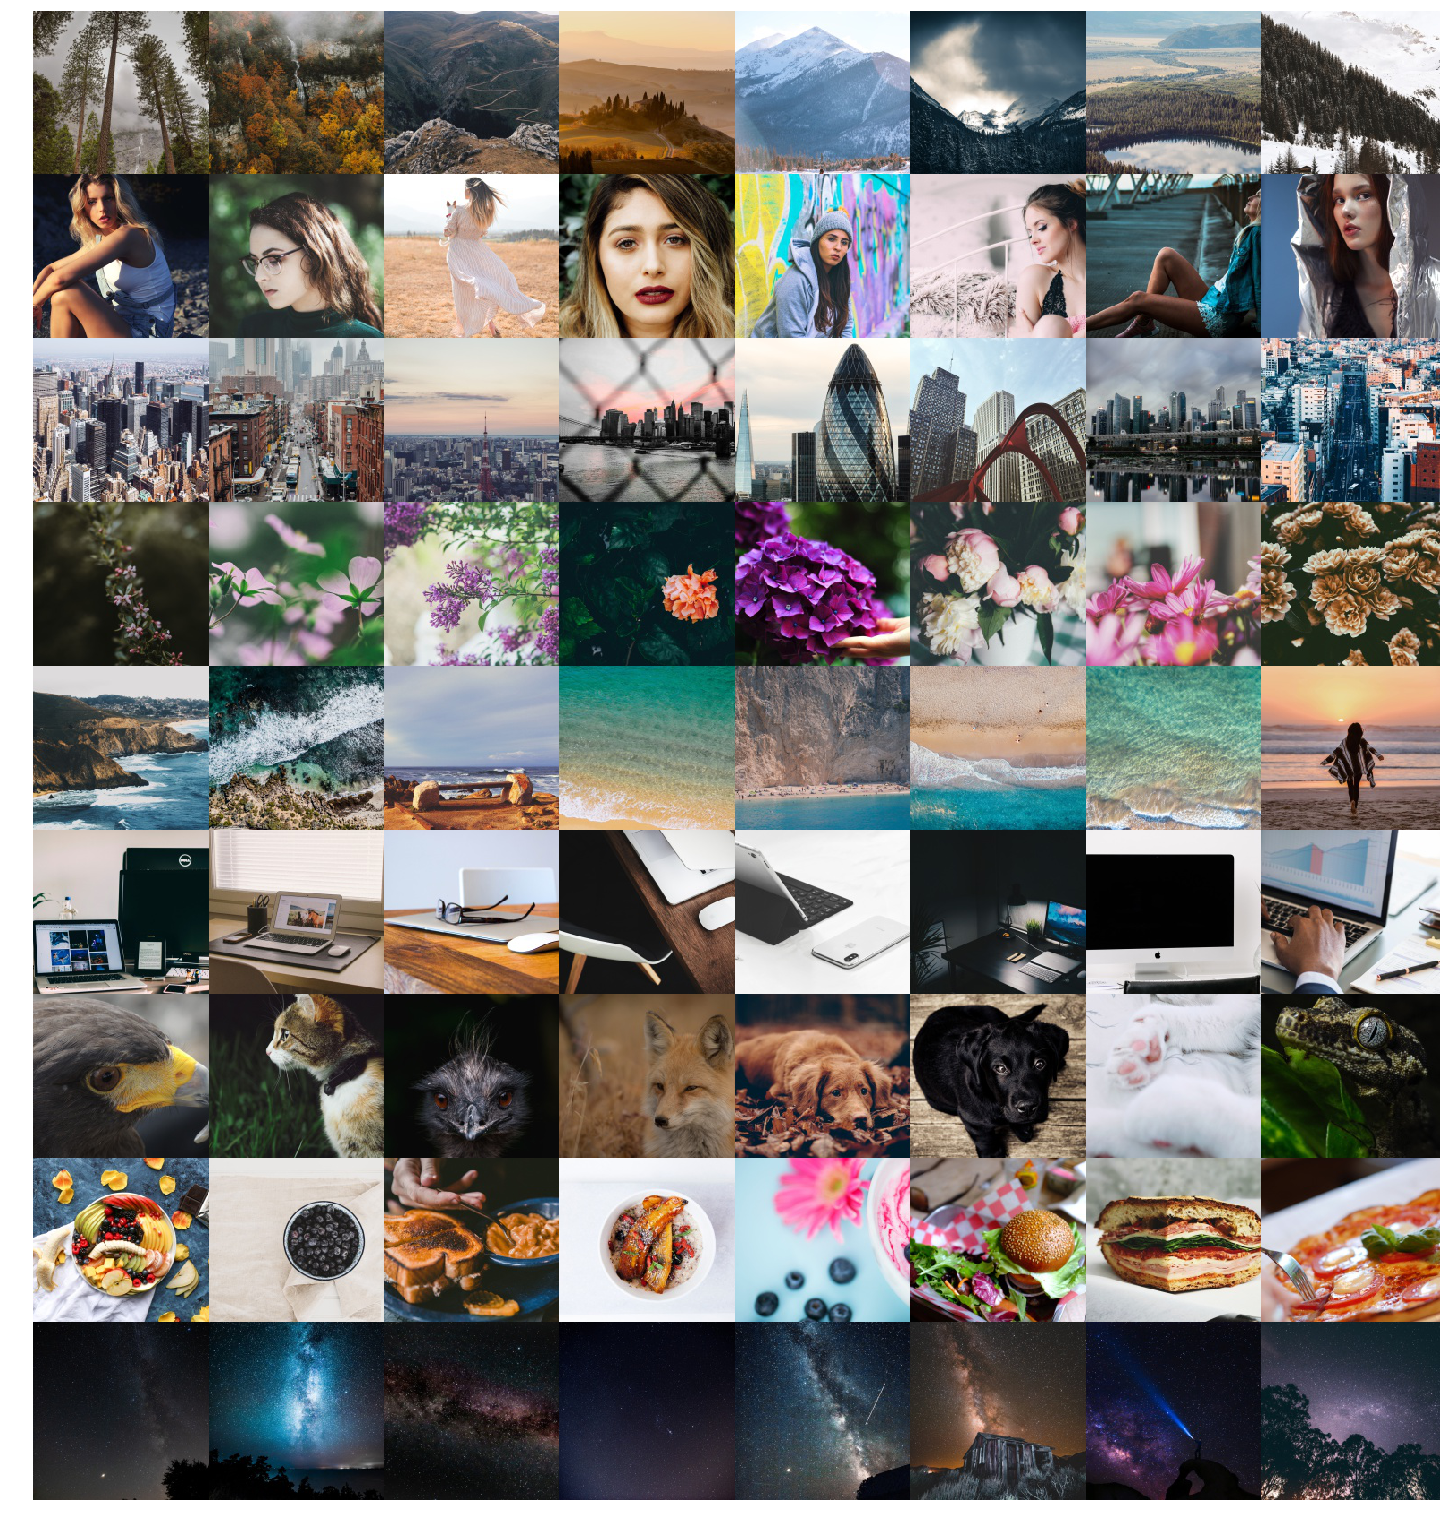

In [18]:
rows = min(d, 9)
cols = 8

plot = plt.figure(figsize=(19, 20))
m = 1
for k in range(rows):
    r = np.array(images)[np.argsort(H[k])[::-1][:cols:]]
    for q in r:
        img = imageio.imread(f'/home/dominik/Datasets/Unsplash/datasets/squarecrop-200px/images/{q}.jpg')
        plt.subplot(rows, cols, m)
        m += 1
        plt.imshow(img)
        plt.axis('off')
        
plt.tight_layout(pad=-3.5)
plt.show()
plt.close()

Each row above ↑ contains related images according to the unsupervised NMF. This is *not* a computer vision based approach but rather an solely based on the similarity of image labels.  
The categories for each row are exactly the related tag categories above.

## Singular value decomposition (SVD)

In [19]:
%%time
U, s, Vh = scipy.linalg.svd(occurrence_matrix.toarray(), full_matrices=False)
U.shape, s.shape, Vh.shape

CPU times: user 3min 4s, sys: 1.03 s, total: 3min 5s
Wall time: 46.9 s


![svd](svd.png)

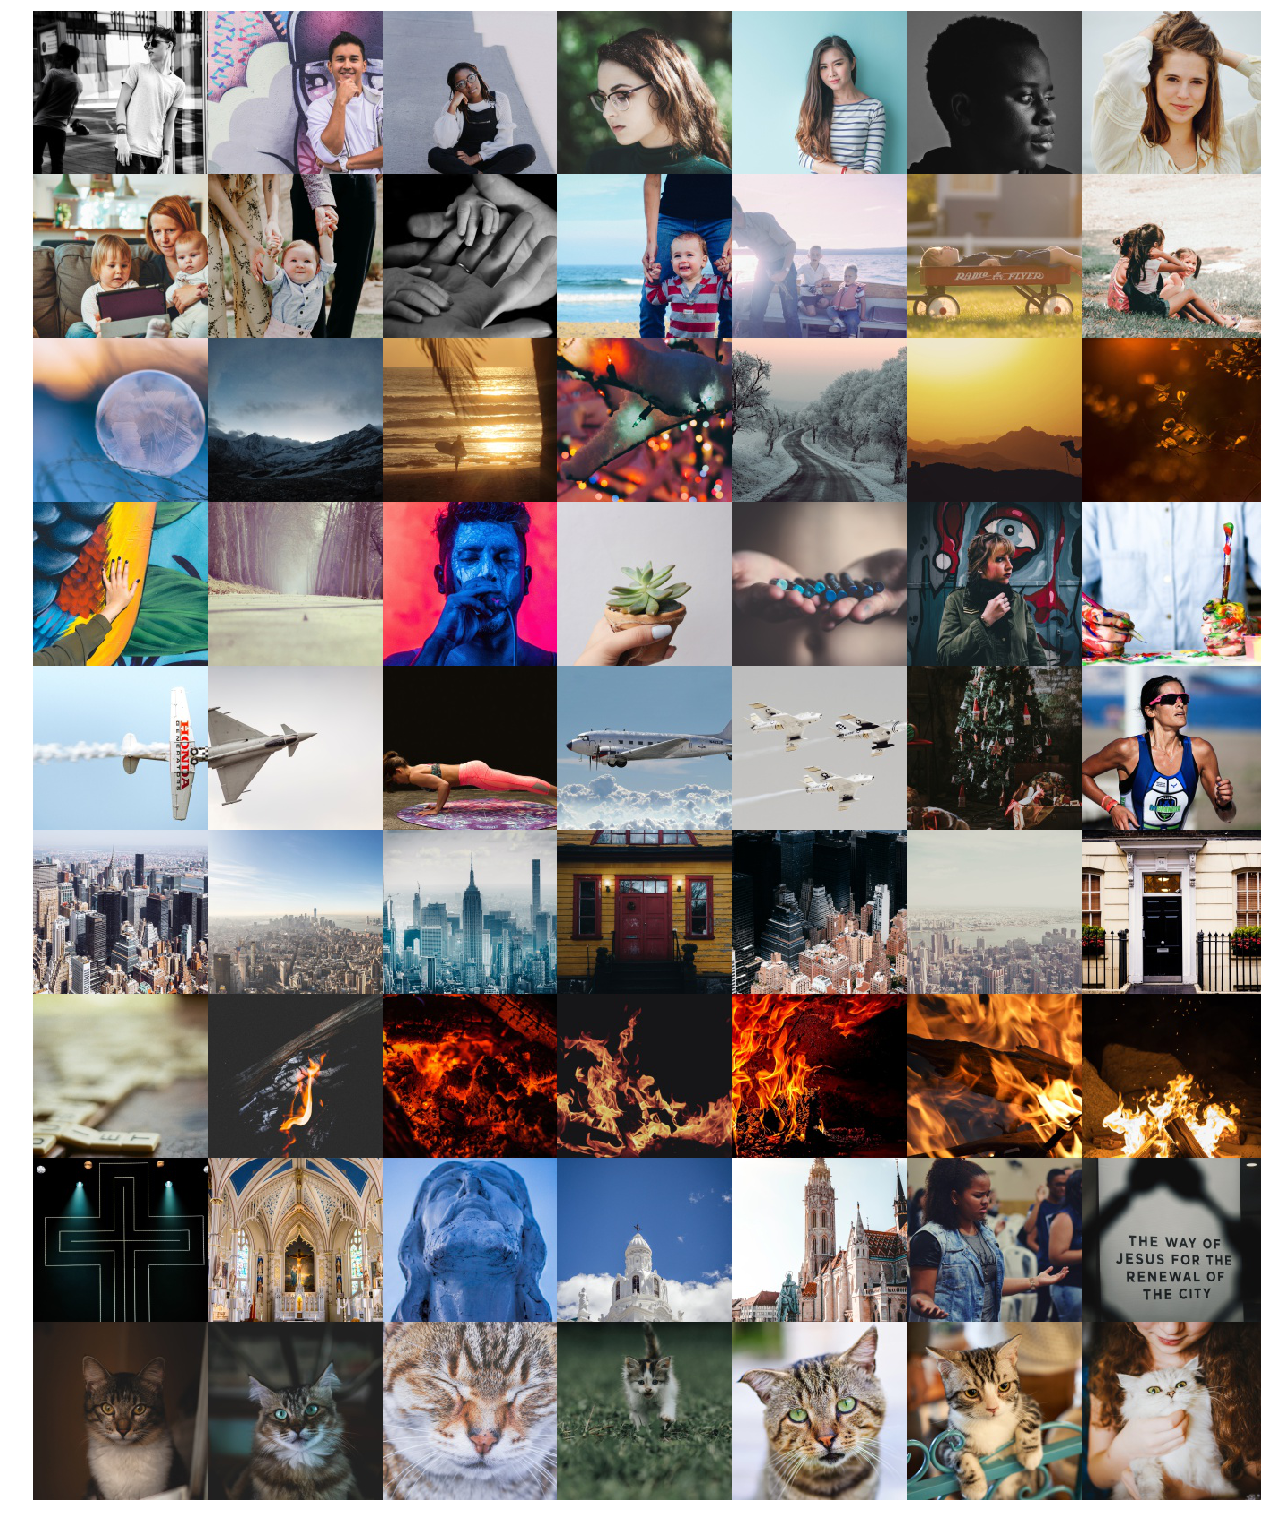

In [22]:
rows = 9
cols = 7

plot = plt.figure(figsize=(16.5, 20))
m = 1
for k in range(1, 1+10*rows, 10):
    r = np.array(images)[np.argsort(Vh[k])[:2*cols:2]]
    for q in r:

        img = imageio.imread(f'/home/dominik/Datasets/Unsplash/datasets/squarecrop-200px/images/{q}.jpg')
        plt.subplot(rows, cols, m)
        m += 1
        plt.imshow(img)
        plt.axis('off')
        
plt.tight_layout(pad=-3.5)
plt.show()
plt.close()